In [41]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
from tqdm.notebook import tqdm
import sklearn
import mnist
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import random
import wandb
from sklearn.model_selection import train_test_split

device = 'cuda' if torch.cuda.is_available() else 'cpu'

seed = 28
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)
if device =='cuda':
    torch.cuda.manual_seed(seed)
    


plt.style.use('seaborn')
device

'cuda'

## Load Data

In [2]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

test_images = mnist.test_images()
test_labels = mnist.test_labels()

train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

(-0.5, 27.5, 27.5, -0.5)

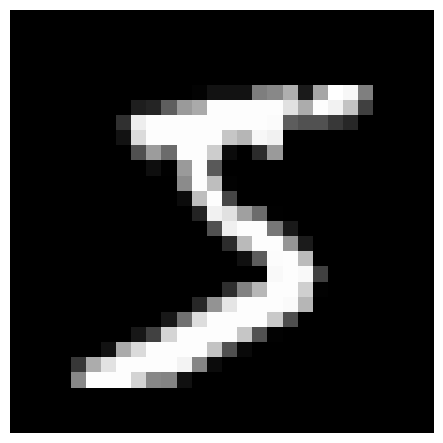

In [3]:
plt.imshow(train_images[0], cmap='gray')
plt.axis('off')

## SIFT-BoVW-SVM

#### Q1 Bag of Visual Word using SIFT features

In [33]:
class KMeansTorch:
    def __init__(self, num_clusters, max_iters=200, device='cuda'):
        self.num_clusters = num_clusters
        self.max_iters = max_iters
        self.device = device
        self.centroids = None

    def forward(self, X):
        X = torch.from_numpy(np.concatenate(X)).to(self.device)
        N, D = X.shape
        self.centroids = X[torch.randperm(N)[:self.num_clusters]].to(self.device)
        
        with torch.no_grad():
            for _ in tqdm(range(self.max_iters)):
                distances = torch.cdist(X, self.centroids)
                assignments = torch.argmin(distances, dim=1)
                for i in range(self.num_clusters):
                    cluster_points = X[assignments == i]
                    if len(cluster_points) > 0:
                        self.centroids[i] = cluster_points.mean(dim=0)

    def fit(self, X):
        self.forward(X)

    def predict(self, X): 
        X = torch.from_numpy(X.astype(np.float32)).to(self.device)
        with torch.no_grad():
            distances = torch.cdist(X, self.centroids)
            assignments = torch.argmin(distances, dim=1)
        return assignments.cpu()


In [36]:
class BoW:
    def __init__(self,
                 images,
                 labels,
                 n_clusters,):

        self.images = images
        self.labels = labels
        self.n_clusters = n_clusters
        self.kmeans = KMeansTorch(num_clusters=self.n_clusters)
        

    def get_sift_features(self, img):
        sift = cv2.SIFT_create()
        keypoints, descriptors = sift.detectAndCompute(img, None)
        return keypoints, descriptors


    def get_all_descriptors(self, imgs):
        all_descriptors, y = [], []
        for i, img in tqdm(enumerate(imgs), total=len(imgs)):
            descriptors = self.get_sift_features(img)[1]
            if descriptors is not None:
                all_descriptors.append(descriptors)
                y.append(self.labels[i])
                
        return all_descriptors, y


    def get_clusters(self, descriptors):
        self.kmeans.fit(descriptors)

    def img2histogram(self, descriptor, kmeans):
        histogram = np.zeros(kmeans.num_clusters)
        word = kmeans.predict(descriptor.astype(np.float64))
        for i in word:
            histogram[i] += 1
        # histogram = np.histogram(word, bins=kmeans.num_clusters, density=False)[0]
        return histogram

    def fit(self, descriptors_path=None):
        if descriptors_path is not None:
            self.descriptors = np.load(descriptors_path, allow_pickle=True)
            print('Descriptors loaded')
        else:
            self.descriptors, self.y = self.get_all_descriptors(self.images)
            print('Descriptors computed')
            

        print('Computing KMeans')
        self.get_clusters(descriptors=self.descriptors)
        print('KMeans Done')

        X = []

        for descriptor in tqdm(self.descriptors):
            X.append(self.img2histogram(descriptor, self.kmeans))

        return np.asarray(X), np.asarray(self.y)



In [42]:

def run_bow(n_clusters=200):
    bag = BoW(images=train_images[:10000],
            labels=train_labels[:10000],
            n_clusters=n_clusters)

    X, y = bag.fit(descriptors_path=None)


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

    X_train.shape, X_test.shape, y_train.shape, y_test.shape

    svm_model = SVC()
    svm_model.fit(X_train, y_train)

    return svm_model.score(X_test, y_test)


In [43]:
run_bow(n_clusters=200)

  0%|          | 0/10000 [00:00<?, ?it/s]

Descriptors computed
Computing KMeans


  0%|          | 0/500 [00:00<?, ?it/s]

KMeans Done


  0%|          | 0/9769 [00:00<?, ?it/s]

0.7901740020470829

#### Q2 Different values of number of clusters

In [ ]:
n_clusters = 1
bow_acc = []
bow_clusters = []

for i in range(1, 20):
    bow_acc.append(run_bow(n_clusters))
    bow_clusters.append(n_clusters)
    if i < 10:
        n_clusters += 20
    else:
        n_clusters += 50

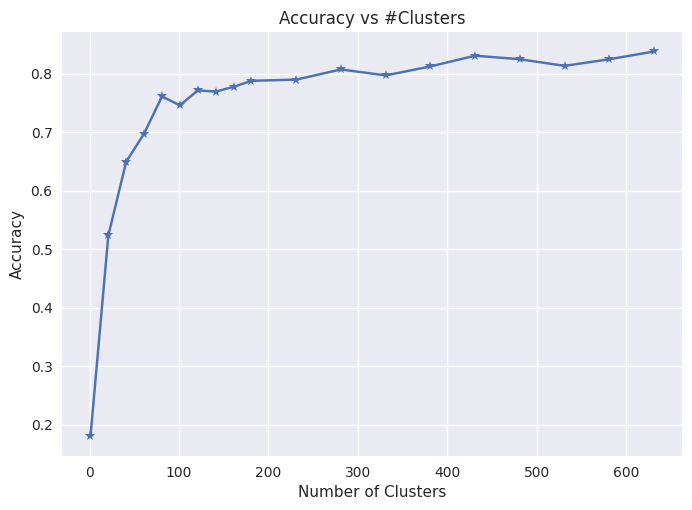

In [62]:
plt.plot(bow_clusters, bow_acc, marker='*')
plt.title('Accuracy vs #Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Accuracy')
plt.show()


#### Q3 Different Hyperparameter Settings

## CNNs and Transformers

#### Q1

In [10]:
from sklearn.model_selection import train_test_split

batch_size = 128
lr = 1e-4

class MNISTDataset(Dataset):
    def __init__(self, images, labels, n_samples=None):
        super().__init__()
        self.images = images
        self.labels = labels
        if n_samples is not None:
            self.images, _, self.labels, _ = train_test_split(self.images, self.labels, train_size=n_samples/len(images), stratify=self.labels)
            
        self.n_samples = len(self.images)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        img = torch.from_numpy(self.images[idx]).view(1, 28, 28)/255.0
        label = torch.tensor(self.labels[idx].astype(np.int64))

        return img.to(torch.float32), label.to(torch.int64)

train_dataset = MNISTDataset(train_images, train_labels)
val_dataset = MNISTDataset(test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [5]:
a, b = next(iter(train_loader))
a.shape, b.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [6]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = self.get_conv_block(1, 6, kernel_size=5, padding=2, stride=1)
        self.block2 = self.get_conv_block(6, 16, kernel_size=5, stride=1)
        self.block3 = self.get_conv_block(16, 120, kernel_size=5, stride=1)
        self.avgpool = nn.AvgPool2d(2)
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 10)

    def get_conv_block(self, in_c, out_c, kernel_size=5, padding=0, stride=1):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=kernel_size, padding=padding, stride=stride),
            nn.Tanh(),
        )

    def forward(self, x):
        # 1, 28, 28
        x = self.block1(x) # 6, 28, 28
        x = self.avgpool(x) # 6, 14, 14
        x = self.block2(x) # 16, 10, 10
        x = self.avgpool(x) # 16, 5, 5
        x = self.block3(x) # 120, 1, 1

        x = x.view(-1, 120)

        x = nn.Tanh()(self.fc1(x)) # 84
        x = self.fc2(x) # 10
        return x


In [7]:
model = LeNet()
with torch.no_grad():
    print(model(a).shape)

torch.Size([128, 10])


In [38]:
from sklearn.metrics import accuracy_score

class Trainer:
    def __init__(self,
                 model,
                 train_loader,
                 val_loader,
                 device,
                 logger=None,
                 lr=1e-4):

        self.device = device
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.logger = logger
        self.loss_fxn = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = lr)
        self.accuracy_fxn = accuracy_score
        self.history = {
            'train_loss': [], 'val_loss': [],
            'train_acc': [], 'val_acc': []
        }

    def training_step(self, x, y):
        y_pred = self.model(x)
        loss = self.loss_fxn(y_pred, y)
        acc = self.accuracy_fxn(y.cpu().numpy(), np.argmax(y_pred.detach().cpu().numpy(), axis=-1))

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss, acc

    def val_step(self, x, y):
        with torch.no_grad():
            y_pred = self.model(x)
            loss = self.loss_fxn(y_pred, y)
            acc = self.accuracy_fxn(y.cpu().numpy(), np.argmax(y_pred.detach().cpu().numpy(), axis=-1))

        return loss, acc

    def go_one_epoch(self, loader, step_fxn):
        loss, acc = 0, 0
        for x, y in loader:
            x, y = x.to(self.device), y.to(self.device)
            loss_batch, acc_batch = step_fxn(x, y)
            loss, acc = loss + loss_batch, acc + acc_batch

        return loss/len(loader), acc/len(loader)

    def train(self, epochs=20):
        for epoch in tqdm(range(epochs)):
            train_loss, train_acc = self.go_one_epoch(self.train_loader, self.training_step)
            val_loss, val_acc = self.go_one_epoch(self.val_loader, self.val_step)

            print(f"[{epoch + 1}] train:[loss:{train_loss:.4f}, acc:{train_acc:.4f}] val:[loss:{val_loss:.4f}, acc:{val_acc:.4f}]")
            
            if self.logger:
                self.logger.log({
                    'train_loss': train_loss,
                    'val_loss': val_loss,
                    'train_acc': train_acc,
                    'val_acc': val_acc 
                })
                
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_acc'].append(val_acc)
            
                
        if self.logger:
            self.logger.finish()

In [ ]:

wandb.init(project='CV-2024-A2', 
           name='LeNet-lr=1e-6',
           config={
               'lr': lr,
               'batch_size': batch_size,
               'optimizer': 'RMSprop',
               'num_conv_layers': 3
           })

In [39]:
trainer = Trainer(
    model=LeNet(),
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    logger=wandb,
    lr=lr
)

In [40]:
trainer.train()

  0%|          | 0/20 [00:00<?, ?it/s]

[1] train:[loss:0.9069, acc:0.7904] val:[loss:0.4859, acc:0.8765]
[2] train:[loss:0.4103, acc:0.8875] val:[loss:0.3339, acc:0.9035]
[3] train:[loss:0.3094, acc:0.9103] val:[loss:0.2651, acc:0.9209]
[4] train:[loss:0.2520, acc:0.9257] val:[loss:0.2171, acc:0.9355]
[5] train:[loss:0.2112, acc:0.9378] val:[loss:0.1840, acc:0.9441]
[6] train:[loss:0.1807, acc:0.9465] val:[loss:0.1575, acc:0.9524]
[7] train:[loss:0.1571, acc:0.9533] val:[loss:0.1399, acc:0.9571]
[8] train:[loss:0.1388, acc:0.9589] val:[loss:0.1224, acc:0.9625]
[9] train:[loss:0.1242, acc:0.9626] val:[loss:0.1113, acc:0.9672]
[10] train:[loss:0.1120, acc:0.9666] val:[loss:0.1018, acc:0.9694]
[11] train:[loss:0.1019, acc:0.9700] val:[loss:0.0929, acc:0.9714]
[12] train:[loss:0.0933, acc:0.9718] val:[loss:0.0851, acc:0.9738]
[13] train:[loss:0.0861, acc:0.9744] val:[loss:0.0804, acc:0.9748]
[14] train:[loss:0.0797, acc:0.9761] val:[loss:0.0740, acc:0.9774]


In [27]:
api = wandb.Api()
run = api.run(f"CV-2024-A2/qph9kyhs")

In [ ]:
run

### Q5 Changing the number of training samples

In [11]:
for n_samples in [600, 1800, 6000, 18000, None]:
    train_dataset = MNISTDataset(train_images, train_labels, n_samples=n_samples)
    val_dataset = MNISTDataset(test_images, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    wandb.init(project='CV-2024-A2', 
               name=f'LeNet-n_samples={n_samples}'
               )
    
    trainer = Trainer(
        model=LeNet(),
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        logger=wandb,
        lr=lr
    )
    
    trainer.train()
    

  0%|          | 0/20 [00:00<?, ?it/s]

[1] train:[loss:1.2614, acc:0.6663] val:[loss:0.5630, acc:0.8612]
[2] train:[loss:0.4445, acc:0.8815] val:[loss:0.3457, acc:0.9030]
[3] train:[loss:0.3202, acc:0.9078] val:[loss:0.2739, acc:0.9210]
[4] train:[loss:0.2616, acc:0.9237] val:[loss:0.2287, acc:0.9317]
[5] train:[loss:0.2213, acc:0.9348] val:[loss:0.1941, acc:0.9424]
[6] train:[loss:0.1917, acc:0.9427] val:[loss:0.1689, acc:0.9503]
[7] train:[loss:0.1683, acc:0.9493] val:[loss:0.1478, acc:0.9566]
[8] train:[loss:0.1492, acc:0.9554] val:[loss:0.1325, acc:0.9621]
[9] train:[loss:0.1338, acc:0.9598] val:[loss:0.1196, acc:0.9654]
[10] train:[loss:0.1204, acc:0.9636] val:[loss:0.1107, acc:0.9674]
[11] train:[loss:0.1095, acc:0.9668] val:[loss:0.1004, acc:0.9698]
[12] train:[loss:0.1002, acc:0.9696] val:[loss:0.0934, acc:0.9718]
[13] train:[loss:0.0918, acc:0.9726] val:[loss:0.0883, acc:0.9732]
[14] train:[loss:0.0851, acc:0.9745] val:[loss:0.0813, acc:0.9754]
[15] train:[loss:0.0790, acc:0.9768] val:[loss:0.0758, acc:0.9763]
[16]

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


train_acc,▁▆▆▇▇▇▇▇▇███████████
train_loss,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▄▅▆▆▇▇▇▇▇▇████████
val_loss,█▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_acc,0.98269
train_loss,0.05772
val_acc,0.98111
val_loss,0.06178


### Q6 Vision Transformer

In [34]:
class VIT(nn.Module):
    def __init__(self,
                 patch_size,
                 input_dim, 
                 heads, 
                 mlp_dim, 
                 dropout, 
                 depth,
                 num_patches):
        
        super().__init__()
        self.input_dim = input_dim
        self.heads = heads
        self.mlp_dim = mlp_dim
        self.dropout = dropout 
        self.depth = depth  
        self.patch_size = patch_size
        self.num_patches = num_patches
        
        self.patch_embedding = nn.Conv2d(1, self.input_dim, kernel_size=self.patch_size, stride=self.patch_size)
        self.positional_embedding = nn.Parameter(torch.randn(1, self.num_patches, self.input_dim))
        
        self.encoder = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(
                    d_model=self.input_dim,
                    nhead=self.heads,
                    dim_feedforward=self.mlp_dim,
                    dropout=self.dropout
                ),
                num_layers=self.depth
            )
        
        self.fc1 = nn.Linear(self.input_dim, 10)
        
    def forward(self, x):
        # x: bs, 1, 28, 28
        
        x = self.patch_embedding(x) # bs, 256, 7, 7
        x = x.flatten(2).transpose(1, 2) # bs, 49, 256
        
        x = x + self.positional_embedding # bs, 49, 256
        
        x = self.encoder(x) # bs, 49, 256
        x = x.mean(dim=1) # bs, 256
        
        x = self.fc1(x) # bs, 10
        
        return x
                
        

In [35]:
image_size = 28
patch_size = 4
num_classes = 10
input_dim = 256
depth = 4
heads = 4
mlp_dim = 256
dropout = 0.1
num_patches = int((image_size * image_size)/(patch_size * patch_size))

##### Training with 6k samples

In [36]:
train_dataset = MNISTDataset(train_images, train_labels, n_samples=6000)
val_dataset = MNISTDataset(test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = VIT(patch_size,
            input_dim, 
            heads, 
            mlp_dim, 
            dropout, 
            depth,
            num_patches)

trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    logger=None,
    lr=lr
)

trainer.train()


  0%|          | 0/20 [00:00<?, ?it/s]

[1] train:[loss:2.3156, acc:0.1001] val:[loss:2.3014, acc:0.1136]
[2] train:[loss:2.3031, acc:0.1207] val:[loss:2.3001, acc:0.1030]
[3] train:[loss:2.2935, acc:0.1327] val:[loss:2.2746, acc:0.2369]
[4] train:[loss:2.1766, acc:0.2621] val:[loss:2.0631, acc:0.3033]
[5] train:[loss:1.9618, acc:0.3630] val:[loss:1.8796, acc:0.4056]
[6] train:[loss:1.8313, acc:0.4338] val:[loss:1.7552, acc:0.5050]
[7] train:[loss:1.7298, acc:0.5040] val:[loss:1.6522, acc:0.5283]
[8] train:[loss:1.6306, acc:0.5312] val:[loss:1.5688, acc:0.5827]
[9] train:[loss:1.5379, acc:0.5743] val:[loss:1.4848, acc:0.5517]
[10] train:[loss:1.4479, acc:0.6069] val:[loss:1.3676, acc:0.6306]
[11] train:[loss:1.3501, acc:0.6408] val:[loss:1.2822, acc:0.7084]
[12] train:[loss:1.2629, acc:0.6786] val:[loss:1.2191, acc:0.6936]
[13] train:[loss:1.1954, acc:0.7047] val:[loss:1.1417, acc:0.7220]
[14] train:[loss:1.1336, acc:0.7179] val:[loss:1.0892, acc:0.7607]
[15] train:[loss:1.0691, acc:0.7467] val:[loss:1.0224, acc:0.7728]
[16]

##### Training with 60K samples

In [37]:
train_dataset = MNISTDataset(train_images, train_labels)
val_dataset = MNISTDataset(test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = VIT(patch_size,
            input_dim, 
            heads, 
            mlp_dim, 
            dropout, 
            depth,
            num_patches)

trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    logger=None,
    lr=lr
)

trainer.train()

  0%|          | 0/20 [00:00<?, ?it/s]

[1] train:[loss:1.9843, acc:0.3276] val:[loss:1.4051, acc:0.6361]
[2] train:[loss:1.0704, acc:0.7402] val:[loss:0.7634, acc:0.8470]
[3] train:[loss:0.6320, acc:0.8592] val:[loss:0.5024, acc:0.8922]
[4] train:[loss:0.4353, acc:0.9013] val:[loss:0.3698, acc:0.9136]
[5] train:[loss:0.3354, acc:0.9195] val:[loss:0.2985, acc:0.9287]
[6] train:[loss:0.2737, acc:0.9313] val:[loss:0.2499, acc:0.9352]
[7] train:[loss:0.2313, acc:0.9400] val:[loss:0.2138, acc:0.9473]
[8] train:[loss:0.2007, acc:0.9479] val:[loss:0.1938, acc:0.9461]
[9] train:[loss:0.1809, acc:0.9515] val:[loss:0.1693, acc:0.9529]
[10] train:[loss:0.1647, acc:0.9556] val:[loss:0.1615, acc:0.9575]
[11] train:[loss:0.1487, acc:0.9598] val:[loss:0.1470, acc:0.9587]
[12] train:[loss:0.1379, acc:0.9616] val:[loss:0.1298, acc:0.9647]
[13] train:[loss:0.1268, acc:0.9653] val:[loss:0.1246, acc:0.9649]
[14] train:[loss:0.1183, acc:0.9664] val:[loss:0.1123, acc:0.9689]
[15] train:[loss:0.1120, acc:0.9679] val:[loss:0.1107, acc:0.9677]
[16]